In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Embedding, GlobalAveragePooling1D, BatchNormalization, Conv1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
#Load and Prepare the IMDb Dataset
vocab_size = 10000
max_review_length = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_review_length)
x_test = pad_sequences(x_test, maxlen=max_review_length)

17464789/17464789 [==============================] - 0s 0us/step


In [3]:
# Display the structure of the first few reviews
for i in range(2):
    print(f"Review {i + 1}:")
    print("Words (Encoded):", x_train[i])
    print("Label:", "Positive" if y_train[i] == 1 else "Negative")
    print()

Review 1:
Words (Encoded): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

In [4]:
# Get the word index and display how words are mapped to integers
word_index = imdb.get_word_index()
print({k: word_index[k] for k in list(word_index)[:5]})

1641221/1641221 [==============================] - 0s 0us/step
{'fawn': 34701, 'tsukino': 52006, 'nunnery': 52007, 'sonja': 16816, 'vani': 63951}


In [5]:
# Print the size of each dataset
print("Training Data:")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("\nTesting Data:")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

Training Data:
x_train shape: (25000, 500)
y_train shape: (25000,)

Testing Data:
x_test shape: (25000, 500)
y_test shape: (25000,)


In [6]:
def deep_narrow_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=max_review_length))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(GlobalAveragePooling1D())

    # Increasing model complexity and reducing regularization
    model.add(Dense(32, activation='relu')) # Increased neurons
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Reduced dropout

    model.add(Dense(32, activation='relu')) # Increased neurons
    model.add(BatchNormalization())
    model.add(Dropout(0.5)) # Reduced dropout
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
deep_model = deep_narrow_model()
deep_model.summary()
history_deep = deep_model.fit(x_train, y_train, epochs=15,batch_size=128, verbose=1, validation_data=(x_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 498, 64)           57664     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0

In [9]:
def wide_shallow_model():
      model = Sequential()
      model.add(Embedding(vocab_size, 300, input_length=max_review_length)) # Wide embedding layer
      model.add(GlobalAveragePooling1D())

      model.add(Dense(512, activation='relu'))
      model.add(BatchNormalization()) # Added Batch Normalization
      model.add(Dropout(0.5))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

      return model

In [10]:
# Wide and Shallow Model
wide_model = wide_shallow_model()
wide_model.summary()
history_wide= wide_model.fit(x_train, y_train, epochs=15,batch_size=128, verbose=1, validation_data=(x_test, y_test))



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          3000000   
                                                                 
 global_average_pooling1d_1  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 512)               154112    
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

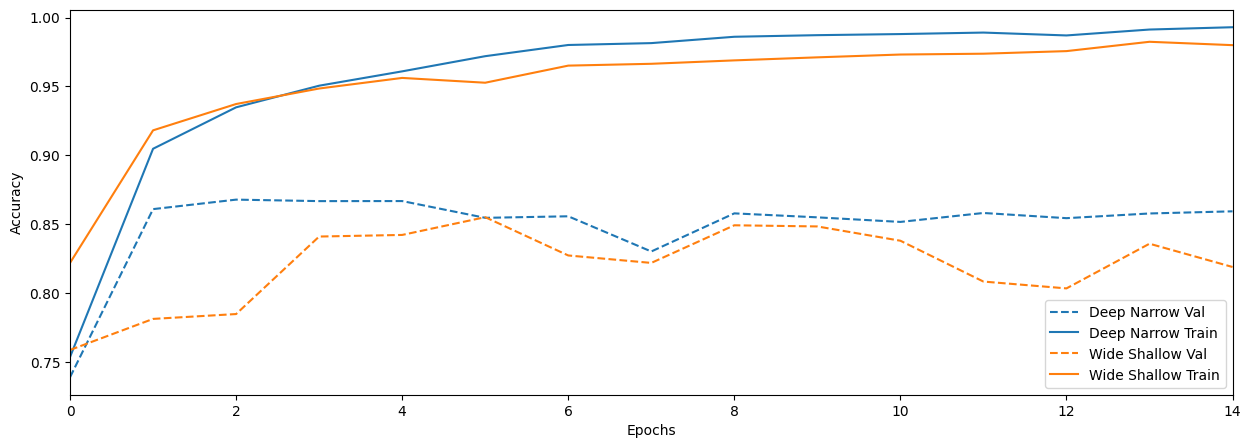

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history_deep' and 'history_wide' are the training histories of the deep and wide models, respectively.

# Plotting
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(15,5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

plot_history([('deep narrow', history_deep),
              ('wide shallow', history_wide)])


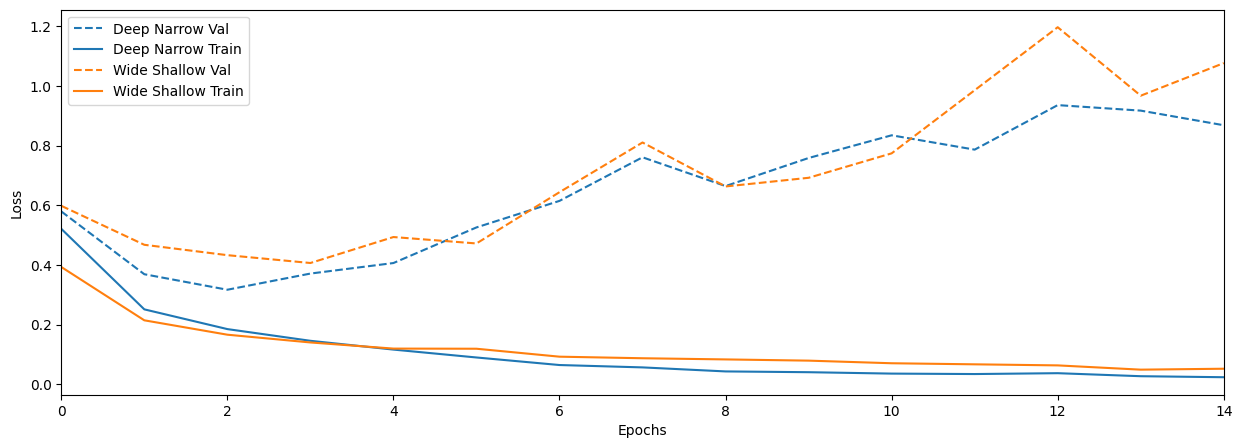

In [12]:
# Plotting function
def plot_history(histories, key='loss'):
    plt.figure(figsize=(15,5))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# Plot for loss
plot_history([('deep narrow', history_deep),
              ('wide shallow', history_wide)], key='loss')